# Import Data and Load/Preprocess the Outcome Variables

In [1]:
import pandas as pd
import numpy as np

In [2]:
brca = pd.read_csv('brca_data_w_subtypes.csv')
brca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Columns: 1941 entries, rs_CLEC3A to histological.type
dtypes: float64(827), int64(1110), object(4)
memory usage: 10.4+ MB


In [3]:
PR_Status = brca['PR.Status']
ER_Status = brca['ER.Status'] 
HER2 = brca['HER2.Final.Status']
HIST = brca['histological.type']

brca_variables = brca.drop(['vital.status', 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type'], axis=1)
brca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Columns: 1941 entries, rs_CLEC3A to histological.type
dtypes: float64(827), int64(1110), object(4)
memory usage: 10.4+ MB


In [4]:
brca_variables.dtypes[~((brca_variables.dtypes == 'float64') | (brca_variables.dtypes == 'int64'))]

Series([], dtype: object)

The data contains 705 observations, 1936 variables (860 copy number variations, 249 mutations, 604 gene expressions and 223 protein levels)

In [5]:
def discretize(x):
    if x == 'Positive' or x == 'infiltrating lobular carcinoma':
        return 1
    elif x == 'Negative' or x == 'infiltrating ductal carcinoma':
        return 0
    else:
        return np.nan

In [6]:
PR_Status = PR_Status.apply(lambda x : discretize(x))
ER_Status = ER_Status.apply(lambda x : discretize(x))
HER2 = HER2.apply(lambda x : discretize(x))
HIST = HIST.apply(lambda x : discretize(x))

# Summary Statistics and Data Preprocessing

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
brca['PR.Status'].value_counts()

Positive                       353
Negative                       193
Not Performed                   28
Performed but Not Available      5
Indeterminate                    4
Name: PR.Status, dtype: int64

In [9]:
PR_Status.value_counts()

1.0    353
0.0    193
Name: PR.Status, dtype: int64

In [10]:
brca['ER.Status'].value_counts()

Positive                       414
Negative                       135
Not Performed                   27
Performed but Not Available      5
Indeterminate                    2
Name: ER.Status, dtype: int64

In [11]:
ER_Status.value_counts()

1.0    414
0.0    135
Name: ER.Status, dtype: int64

In [12]:
brca['HER2.Final.Status'].value_counts()

Negative         457
Positive          86
Equivocal          9
Not Available      8
Name: HER2.Final.Status, dtype: int64

In [13]:
HER2.value_counts()

0.0    457
1.0     86
Name: HER2.Final.Status, dtype: int64

In [14]:
brca['histological.type'].value_counts()

infiltrating ductal carcinoma     574
infiltrating lobular carcinoma    131
Name: histological.type, dtype: int64

In [15]:
HIST.value_counts()

0    574
1    131
Name: histological.type, dtype: int64

# Modeling `PR.Status`

## SVM w/ cross-validation

In [16]:
from sklearn import linear_model, svm
from sklearn.model_selection import cross_val_score

In [28]:
reg = svm.SVC(kernel='linear', C=1, random_state=42)

subset_brca_variables = brca_variables[(PR_Status == 0) | (PR_Status == 1)]
subset_PR_Status = PR_Status[(PR_Status == 0) | (PR_Status == 1)]

In [29]:
scores = cross_val_score(reg, subset_brca_variables, subset_PR_Status, cv=5, scoring='accuracy')
scores

array([0.8       , 0.8440367 , 0.78899083, 0.80733945, 0.81651376])

In [30]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.81 accuracy with a standard deviation of 0.02


## Logistic Regression

In [33]:
lr = linear_model.LogisticRegression(random_state=42)

In [34]:
scores2 = cross_val_score(lr, subset_brca_variables, subset_PR_Status, cv=5, scoring='accuracy')
scores2

/Users/zihanxiong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zihanxiong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

array([0.81818182, 0.86238532, 0.81651376, 0.80733945, 0.83486239])

In [35]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores2.mean(), scores2.std()))

0.83 accuracy with a standard deviation of 0.02


# Modeling `histological.type`

In [23]:
subset_brca_variables = brca_variables[(HIST == 0) | (HIST == 1)]
subset_HIST_Status = HIST[(HIST == 0) | (HIST == 1)]

## KNN

In [24]:
from sklearn.neighbors import KNeighborsRegressor

ks = np.arange(1, 11)
means = []
stds = []
for k in ks:
    reg = KNeighborsRegressor(n_neighbors=k)

    scores = cross_val_score(reg, subset_brca_variables, subset_HIST_Status, cv=5, scoring="roc_auc")

    means.append(scores.mean())
    stds.append(scores.std())

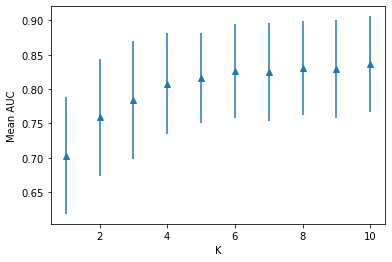

In [25]:
plt.errorbar(ks, means, stds, linestyle='None', marker='^')
plt.xlabel("K")
plt.ylabel("Mean AUC")
plt.show()

## Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

depths = np.arange(1, 11)
means = []
stds = []
for d in depths:
    reg = RandomForestClassifier(max_depth=d, random_state=0)

    scores = cross_val_score(reg, subset_brca_variables, subset_HIST_Status, cv=5, scoring="roc_auc")

    means.append(scores.mean())
    stds.append(scores.std())

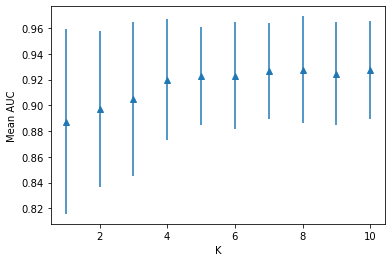

In [27]:
plt.errorbar(ks, means, stds, linestyle='None', marker='^')
plt.xlabel("K")
plt.ylabel("Mean AUC")
plt.show()

# Variable Selection for All Outcomes